Epoch 1/20 — loss: 4.3576
Epoch 2/20 — loss: 2.9315
Epoch 3/20 — loss: 1.8260
Epoch 4/20 — loss: 1.0975
Epoch 5/20 — loss: 0.6550
Epoch 6/20 — loss: 0.4021
Epoch 7/20 — loss: 0.2630
Epoch 8/20 — loss: 0.1812
Epoch 9/20 — loss: 0.1282
Epoch 10/20 — loss: 0.0886
Epoch 11/20 — loss: 0.0633
Epoch 12/20 — loss: 0.0437
Epoch 13/20 — loss: 0.0274
Epoch 14/20 — loss: 0.0180
Epoch 15/20 — loss: 0.0100
Epoch 16/20 — loss: 0.0061
Epoch 17/20 — loss: 0.0029
Epoch 18/20 — loss: 0.0014
Epoch 19/20 — loss: 0.0012
Epoch 20/20 — loss: 0.0007
Test Accuracy: 0.8563
Precision (macro): 0.8501
Recall    (macro): 0.8374
F1-score  (macro): 0.8421


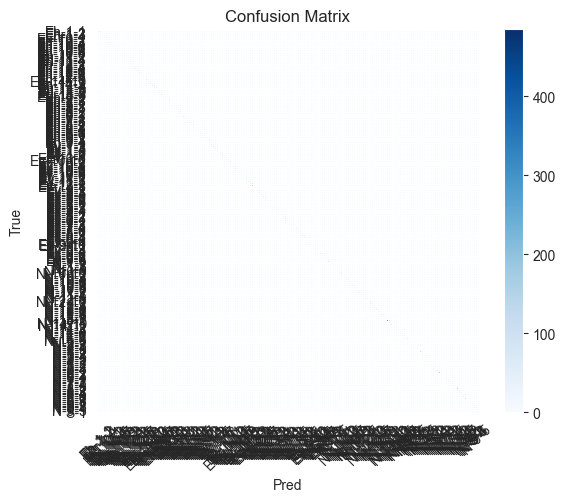

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# -----------------------------
# 0. Configuration
# -----------------------------
device         = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir       = '../all'                   # image data path
text_data_path = 'Final Dataset-Texts.xlsx' # text-data Excel
image_size     = (32, 32)
batch_size     = 32
num_epochs     = 20
lr_img         = 1e-3
lr_bert        = 5e-5
weight_decay   = 1e-2

# -----------------------------
# 1. Image loading & preprocessing
# -----------------------------
images, labels = [], []
for cls in os.listdir(data_dir):
    cls_path = os.path.join(data_dir, cls)
    if not os.path.isdir(cls_path):
        continue
    for fn in os.listdir(cls_path):
        if fn.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            try:
                img = Image.open(os.path.join(cls_path, fn)).convert('L')
                img = img.resize(image_size)
                arr = np.array(img, dtype=np.float32) / 255.0
                images.append(arr)
                labels.append(cls)
            except Exception as e:
                print(f"Error reading {fn}: {e}")

images = np.stack(images)  # (N, H, W)
le     = LabelEncoder()
y      = le.fit_transform(labels)
num_classes = len(le.classes_)

class ImageDataset(Dataset):
    def __init__(self, imgs, lbls):
        self.imgs = imgs
        self.lbls = lbls
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        x = np.expand_dims(self.imgs[idx], 0)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(self.lbls[idx], dtype=torch.long)

idx = np.arange(len(images))
tidx, vidx = train_test_split(idx, test_size=0.2, random_state=42, stratify=y)
train_ds = ImageDataset(images[tidx], y[tidx])
test_ds  = ImageDataset(images[vidx], y[vidx])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

# -----------------------------
# 2. Text prior extraction + BERT fine-tuning
# -----------------------------
df = pd.read_excel(text_data_path)
combined_text = df['Type'].iloc[0] + ' ' + df['List of Store Names'].iloc[0]

tokenizer  = BertTokenizer.from_pretrained("bert-base-chinese")
bert_model = BertModel.from_pretrained("bert-base-chinese").to(device)

# Freeze all layers
for p in bert_model.parameters():
    p.requires_grad = False
# Unfreeze the last two encoder layers
for name, p in bert_model.named_parameters():
    if "encoder.layer.10" in name or "encoder.layer.11" in name:
        p.requires_grad = True
bert_model.train()

# Pre-compute a fixed text vector
with torch.no_grad():
    txt_inputs = tokenizer(combined_text, return_tensors="pt", truncation=True, padding=True)
    txt_inputs = {k: v.to(device) for k, v in txt_inputs.items()}
    txt_vec = bert_model(**txt_inputs).last_hidden_state[:, 0, :].squeeze(0).to(device)

# -----------------------------
# 3. Define the ResNet + text-fusion model
# -----------------------------
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, 3, stride, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(planes)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, 3, 1, 1, bias=False)
        self.bn2   = nn.BatchNorm2d(planes)
        self.down  = None
        if stride != 1 or in_planes != planes:
            self.down = nn.Sequential(
                nn.Conv2d(in_planes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes)
            )
    def forward(self, x):
        idt = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.down:
            idt = self.down(x)
        return self.relu(out + idt)

class ResNetFusionText(nn.Module):
    def __init__(self, block, layers, num_classes, in_ch=1, text_dim=768):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(in_ch, 64, 3, 1, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        def mk(planes, cnt, stride):
            seq = [block(self.in_planes, planes, stride)]
            self.in_planes = planes * block.expansion
            for _ in range(1, cnt):
                seq.append(block(self.in_planes, planes))
            return nn.Sequential(*seq)
        self.layer1 = mk(64,  layers[0], 1)
        self.layer2 = mk(128, layers[1], 2)
        self.layer3 = mk(256, layers[2], 2)
        self.layer4 = mk(512, layers[3], 2)
        self.avgp   = nn.AdaptiveAvgPool2d((1, 1))
        self.w_img  = nn.Parameter(torch.tensor(1.0, device=device))
        self.w_text = nn.Parameter(torch.tensor(1.0, device=device))
        self.fc     = nn.Linear(512 + text_dim, num_classes)
    def forward(self, x, text_vec):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x); x = self.layer2(x)
        x = self.layer3(x); x = self.layer4(x)
        x = self.avgp(x).flatten(1)
        B = x.size(0)
        img_f = x * self.w_img
        txt_f = text_vec.unsqueeze(0).expand(B, -1) * self.w_text
        return self.fc(torch.cat([img_f, txt_f], dim=1))

def build_model(n_cls):
    return ResNetFusionText(BasicBlock, [2, 2, 2, 2], n_cls).to(device)

model = build_model(num_classes)

# -----------------------------
# 4. Optimizer & LR scheduler
# -----------------------------
optimizer = optim.AdamW([
    {'params': model.parameters(),                       'lr': lr_img},
    {'params': bert_model.encoder.layer[10].parameters(),'lr': lr_bert},
    {'params': bert_model.encoder.layer[11].parameters(),'lr': lr_bert},
], weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
criterion = nn.CrossEntropyLoss()

# -----------------------------
# 5. Training
# -----------------------------
for epoch in range(num_epochs):
    model.train()
    bert_model.train()
    total_loss = 0.0
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        inputs = tokenizer(combined_text, return_tensors="pt", truncation=True, padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        batch_txt_vec = bert_model(**inputs).last_hidden_state[:, 0, :].squeeze(0)
        optimizer.zero_grad()
        loss = criterion(model(imgs, batch_txt_vec), lbls)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs} — loss: {total_loss/len(train_ds):.4f}")

# -----------------------------
# 6. Testing & metrics + visualization
# -----------------------------
model.eval()
bert_model.eval()
all_true, all_pred = [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        inputs = tokenizer(combined_text, return_tensors="pt", truncation=True, padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        batch_txt_vec = bert_model(**inputs).last_hidden_state[:, 0, :].squeeze(0)
        preds = model(imgs, batch_txt_vec).argmax(dim=1)
        all_true.extend(lbls.cpu().tolist())
        all_pred.extend(preds.cpu().tolist())

# Accuracy
print(f"Test Accuracy: {(np.array(all_pred) == np.array(all_true)).mean():.4f}")
# Other metrics
print(f"Precision (macro): {precision_score(all_true, all_pred, average='macro'):.4f}")
print(f"Recall    (macro): {recall_score(all_true, all_pred, average='macro'):.4f}")
print(f"F1-score  (macro): {f1_score(all_true, all_pred, average='macro'):.4f}")

# Confusion matrix
cm = confusion_matrix(all_true, all_pred)
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='Blues')
plt.xticks(range(num_classes), le.classes_, rotation=45)
plt.yticks(range(num_classes), le.classes_)
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
